# Creating Cross-Stitch Templates from Image

## Imports

In [1]:
from PIL import Image
from skimage import io, color
import requests
from io import BytesIO
import math
from itertools import combinations
import struct
import colorsys
from collections import OrderedDict

In [2]:
import scipy
import scipy.misc
import scipy.cluster
from sklearn.linear_model import LassoCV
from sklearn.cluster import KMeans
from sklearn import linear_model, metrics, model_selection
from sklearn.linear_model import ElasticNet
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

D:\Anaconda\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
import cv2 as cv2
import numpy as np
import scipy.io
import pandas as pd

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

## Data

In [5]:
data = scipy.io.loadmat('data/kulerData.mat')
hueProbs = scipy.io.loadmat('data/hueProbsRGB.mat')
huedata = hueProbs['hueProbs']

In [6]:
palette = data['data']
rating = data['targets']

In [7]:
data = hueProbs['hueProbs']

In [8]:
hueProb  = huedata['hueProb']
hueJoint = huedata['hueJoint']
hueAdjacency = huedata['hueAdjacency']
hueSaturation = huedata['hueSaturation']
hueValue = huedata['hueValue']
hueJointRating = huedata['hueJointRating']
hueAdjacencyRating = huedata['hueAdjacencyRating']
hueSaturationRating = huedata['hueSaturationRating']
hueValueRating = huedata['hueValueRating']
hueRatingFactor = huedata['hueRatingFactor']

## Functions for color conversion

In [ ]:
def rgb2hsv(r, g, b):
    h, s, v, = colorsys.rgb_to_hsv(r, g, b)
    return h, s, v

In [10]:
def rgb2chsv(r, g, b):
    h, s, v = colorsys.rgb_to_hsv(r, g, b)
    d1 = s*math.cos(h)
    d2 = s*math.sin(h)
    d3 = v
    return d1, d2, d3

In [11]:
def rgb2lab(r, g, b):
    inputColor = [r, g, b]
    num = 0
    RGB = [0, 0, 0]
    for value in inputColor:
        value = float(value) / 255
        if value > 0.04045:
            value = ( ( value + 0.055 ) / 1.055 ) ** 2.4
        else:
            value = value / 12.92
        RGB[num] = value * 100
        num = num + 1
    XYZ = [0, 0, 0,]
    X = RGB [0] * 0.4124 + RGB [1] * 0.3576 + RGB [2] * 0.1805
    Y = RGB [0] * 0.2126 + RGB [1] * 0.7152 + RGB [2] * 0.0722
    Z = RGB [0] * 0.0193 + RGB [1] * 0.1192 + RGB [2] * 0.9505
    XYZ[ 0 ] = round( X, 4 )
    XYZ[ 1 ] = round( Y, 4 )
    XYZ[ 2 ] = round( Z, 4 )
    XYZ[ 0 ] = float( XYZ[ 0 ] ) / 95.047         # ref_X =  95.047   Observer= 2°, Illuminant= D65
    XYZ[ 1 ] = float( XYZ[ 1 ] ) / 100.0          # ref_Y = 100.000
    XYZ[ 2 ] = float( XYZ[ 2 ] ) / 108.883        # ref_Z = 108.883
    num = 0
    for value in XYZ:
        if value > 0.008856:
            value = value ** ( 0.3333333333333333 )
        else:
            value = ( 7.787 * value ) + ( 16 / 116 )
        XYZ[num] = value
        num = num + 1
    Lab = [0, 0, 0]
    L = ( 116 * XYZ[ 1 ] ) - 16
    a = 500 * ( XYZ[ 0 ] - XYZ[ 1 ] )
    b = 200 * ( XYZ[ 1 ] - XYZ[ 2 ] )
    Lab [ 0 ] = round( L, 4 )
    Lab [ 1 ] = round( a, 4 )
    Lab [ 2 ] = round( b, 4 )
    return Lab[0], Lab[1], Lab[2]

In [12]:
def find_dif(col1, col2):
    d1 = abs(col1[0] - col2[0])
    d2 = abs(col1[1] - col2[2])
    d3 = abs(col1[0] - col2[0])
    return d1, d2, d3

## Creating a feature vector 

In [13]:
def create_features(palette, hueProb, hueJoint, hueAdjacency):
    rgb = np.zeros((len(palette), 3))
    lab = np.zeros((len(palette), 3))
    hsv = np.zeros((len(palette), 3))
    chsv = np.zeros((len(palette), 3))
    rgb_sorted = np.zeros((len(palette), 3))
    lab_sorted = np.zeros((len(palette), 3))
    hsv_sorted = np.zeros((len(palette), 3))
    chsv_sorted = np.zeros((len(palette), 3))
    rgb_diff = np.zeros((4, 3))
    lab_diff = np.zeros((4, 3))
    hsv_diff = np.zeros((4, 3))
    chsv_diff = np.zeros((4, 3))
    rgb_diff_s = np.zeros((4, 3))
    lab_diff_s = np.zeros((4, 3))
    hsv_diff_s = np.zeros((4, 3))
    chsv_diff_s = np.zeros((4, 3))
    rgb_mean = np.zeros(3)
    rgb_std = np.zeros(3)
    rgb_median = np.zeros(3)
    rgb_min = np.zeros(3)
    rgb_max = np.zeros(3)
    lab_mean = np.zeros(3)
    lab_std = np.zeros(3)
    lab_median = np.zeros(3)
    lab_min = np.zeros(3)
    lab_max = np.zeros(3)
    hsv_mean = np.zeros(3)
    hsv_std = np.zeros(3)
    hsv_median = np.zeros(3)
    hsv_min = np.zeros(3)
    hsv_max = np.zeros(3)
    chsv_mean = np.zeros(3)
    chsv_std = np.zeros(3)
    chsv_median = np.zeros(3)
    chsv_min = np.zeros(3)
    chsv_max = np.zeros(3)
    rgb_mmd = np.zeros(3)
    lab_mmd = np.zeros(3)
    hsv_mmd = np.zeros(3)
    chsv_mmd = np.zeros(3)
    hj = np.zeros((5, 5))
    ha = np.zeros((5, 5))
    for i in range(len(palette)):
        rgb[i] = palette[i]
        lab[i] = rgb2lab(rgb[i][0], rgb[i][1], rgb[i][2])
        hsv[i] = rgb2hsv(rgb[i][0], rgb[i][1], rgb[i][2])
        chsv[i] = rgb2chsv(rgb[i][0], rgb[i][1], rgb[i][2]) 
        rgb_sorted[i] = sorted(rgb[i])
        lab_sorted[i] = sorted(lab[i])
        hsv_sorted[i] = sorted(hsv[i])
        chsv_sorted[i] = sorted(chsv[i])
    for i in range(4):
        rgb_diff[i] = find_dif(rgb[i], rgb[i+1])
        lab_diff[i] = find_dif(lab[i], lab[i+1])
        hsv_diff[i] = find_dif(hsv[i], hsv[i+1])
        chsv_diff[i] = find_dif(chsv[i], chsv[i+1])
        rgb_diff_s[i] = sorted(rgb_diff[i])
        lab_diff_s[i] = sorted(lab_diff[i])
        hsv_diff_s[i] = sorted(hsv_diff[i])
        chsv_diff_s[i] = sorted(chsv_diff[i])
    for i in range(3):
        rgb_mean[i] = np.mean(rgb[:, i])
        rgb_std[i] = np.std(rgb[:, i])
        rgb_median[i] = np.median(rgb[:, i])
        rgb_min[i] = min(rgb[:, i])
        rgb_max[i] = max(rgb[:, i])
        lab_mean[i] = np.mean(lab[:, i])
        lab_std[i] = np.std(lab[:, i])
        lab_median[i] = np.median(lab[:, i])
        lab_min[i] = min(lab[:, i])
        lab_max[i] = max(lab[:, i])
        hsv_mean[i] = np.mean(hsv[:, i])
        hsv_std[i] = np.std(hsv[:, i])
        hsv_median[i] = np.median(hsv[:, i])
        hsv_min[i] = min(hsv[:, i])
        hsv_max[i] = max(hsv[:, i])
        chsv_mean[i] = np.mean(chsv[:, i])
        chsv_std[i] = np.std(chsv[:, i])
        chsv_median[i] = np.median(chsv[:, i])
        chsv_min[i] = min(chsv[:, i])
        chsv_max[i] = max(chsv[:, i])
        rgb_mmd[i] = rgb_max[i] - rgb_min[i]
        lab_mmd[i] = lab_max[i] - lab_min[i]
        hsv_mmd[i] = hsv_max[i] - hsv_min[i]
        chsv_mmd[i] = chsv_max[i] - chsv_min[i]
        
    hsv_indices = (hsv[:, 0]*360).astype(int)
    hp_mean = np.mean(hueProb[0][0][hsv_indices]/100.0)
    hp_std = np.std(hueProb[0][0][hsv_indices]/100.0)
    hp_min = np.amin(hueProb[0][0][hsv_indices]/100.0)
    hp_max = np.amax(hueProb[0][0][hsv_indices]/100.0)
    hp_mean_log = np.mean(np.log(hueProb[0][0][hsv_indices]/100.0))
    hp_std_log = np.std(np.log(hueProb[0][0][hsv_indices]/100.0))
    hp_min_log = np.amin(np.log(hueProb[0][0][hsv_indices]/100.0))
    hp_max_log = np.amax(np.log(hueProb[0][0][hsv_indices]/100.0))
    
    for i in range(5):
        for j in range(5):
            hj[i][j] = hueJoint[0][0][hsv_indices[i]][hsv_indices[j]]
            ha[i][j] = hueAdjacency[0][0][hsv_indices[i]][hsv_indices[j]]
            
    hj_mean = np.mean(hj/100.0)
    hj_std = np.std(hj/100.0)
    hj_min = np.min(hj/100.0)
    hj_max = np.max(hj/100.0)
    hj_mean_log = np.mean(np.log((hj/100.0)))
    hj_std_log = np.std(np.log((hj/100.0)))
    hj_min_log = np.min(np.log((hj/100.0)))
    hj_max_log = np.max(np.log((hj/100.0)))
    
    
    ha_mean = np.mean(ha/100.0)
    ha_std = np.std(ha/100.0)
    ha_min = np.min(ha/100.0)
    ha_max = np.max(ha/100.0)
    ha_mean_log = np.mean(np.log((ha/100.0)))
    ha_std_log = np.std(np.log((ha/100.0)))
    ha_min_log = np.min(np.log((ha/100.0)))
    ha_max_log = np.max(np.log((ha/100.0)))

    result = (np.ravel(rgb), np.ravel(rgb_sorted), np.ravel(rgb_diff), np.ravel(rgb_diff_s), np.ravel(rgb_mean),np.ravel(rgb_std), np.ravel(rgb_median), np.ravel(rgb_max), np.ravel(rgb_min), np.ravel(rgb_mmd), np.ravel(lab), np.ravel(lab_sorted), np.ravel(lab_diff), np.ravel(lab_diff_s), np.ravel(lab_mean),np.ravel(lab_std), np.ravel(lab_median), np.ravel(lab_max), np.ravel(lab_min), np.ravel(lab_mmd), np.ravel(chsv), np.ravel(chsv_sorted), np.ravel(chsv_diff), np.ravel(chsv_diff_s), np.ravel(chsv_mean),np.ravel(chsv_std), np.ravel(chsv_median), np.ravel(chsv_max), np.ravel(chsv_min), np.ravel(chsv_mmd), np.ravel(hsv), np.ravel(hsv_sorted), np.ravel(hsv_diff), np.ravel(hsv_diff_s), np.ravel(hsv_mean),np.ravel(hsv_std), np.ravel(hsv_median), np.ravel(hsv_max), np.ravel(hsv_min), np.ravel(hsv_mmd), np.ravel(hp_mean), np.ravel(hp_std), np.ravel(hp_max), np.ravel(hp_min), np.ravel(hp_mean_log), np.ravel(hp_std_log), np.ravel(hp_max_log), np.ravel(hp_min_log), np.ravel(ha_mean), np.ravel(ha_std), np.ravel(ha_max), np.ravel(ha_min), np.ravel(ha_mean_log), np.ravel(ha_std_log), np.ravel(ha_max_log), np.ravel(ha_min_log), np.ravel(hj_mean), np.ravel(hj_std), np.ravel(hj_max), np.ravel(hj_min), np.ravel(hj_mean_log), np.ravel(hj_std_log), np.ravel(hj_max_log), np.ravel(hj_min_log))
    r = np.concatenate(result).ravel()
    #result = np.ndarray.flatten(np.array(np.ravel(rgb), np.ravel(rgb_sorted), np.ravel(rgb_diff), np.ravel(rgb_diff_s), np.ravel(rgb_mean), np.ravel(rgb_std), np.ravel(rgb_median), np.ravel(rgb_min), np.ravel(rgb_max), np.ravel(rgb_mmd))
    #r = np.ravel(result)
    #print (len(r))
    return r
    
    #print((hueJoint[0][0][(hsv[:, 0]*360).astype(int)]/100.0))
    #print((hueJoint[0][0][(hsv[:, 0]*360).astype(int)][np.transpose((hsv[:, 0]*360).astype(int))])

## Creating and cleaning the features

In [14]:
w = len(palette)
h = 312
features = np.zeros((w, h))

In [15]:
for i in range(w):
    features[i] = create_features(palette[i], hueProb, hueJoint, hueAdjacency)
    if(i%1000 == 0):
        print (int(i/1000.0))

0


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:117: RuntimeWarning: divide by zero encountered in log
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:118: RuntimeWarning: divide by zero encountered in log
D:\Anaconda\lib\site-packages\numpy\core\_methods.py:112: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:119: RuntimeWarning: divide by zero encountered in log
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:120: RuntimeWarning: divide by zero encountered in log


1
2
3
4
5
6
7
8


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:107: RuntimeWarning: divide by zero encountered in log
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:108: RuntimeWarning: divide by zero encountered in log
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:109: RuntimeWarning: divide by zero encountered in log
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:110: RuntimeWarning: divide by zero encountered in log


9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44


In [16]:
features_clean = features
features_clean[np.isnan(features_clean)] = 0
features_clean[np.isinf(features_clean)] = 0

In [17]:
print(np.any(np.isnan(features_clean)))
print(np.all(np.isfinite(features_clean)))

False
True


In [18]:
ratings_clean = rating
ratings_clean[np.isnan(ratings_clean)] = 0
ratings_clean[np.isinf(ratings_clean)] = 0

In [19]:
print(np.any(np.isnan(ratings_clean)))
print(np.all(np.isfinite(ratings_clean)))

False
True


In [20]:
X = features_clean
Y = ratings_clean

In [21]:
X_train,X_test,y_train,y_test=train_test_split(X,Y, test_size=0.3, random_state=31)

## Training a MLP Regressor

In [22]:
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.model_selection import cross_val_predict
from sklearn import cross_validation

In [23]:
from sklearn.neural_network import MLPRegressor
mlp = MLPRegressor(activation='logistic')

In [24]:
mlp.fit(X_train,y_train)

D:\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1306: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLPRegressor(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [25]:
predictions = mlp.predict(X_test)

In [26]:
rmse = np.sqrt(mean_squared_error(y_test,predictions))
rmse

0.6722240895908759

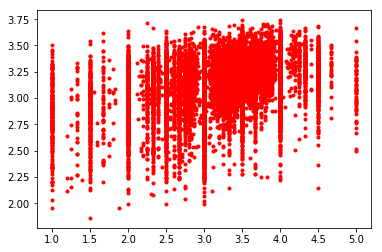

In [27]:
plt.plot(y_test, predictions, 'r.')
plt.show()

# Cross Stitching

## Functions

In [28]:
def pixelate_channel(channel, canvas_height, canvas_width, method=np.median):
    height = channel.shape[0]
    width = channel.shape[1]
    pixel_width = width // canvas_width
    pixel_height = height // canvas_height
    
    if canvas_width > width or canvas_height > height:
        raise ValueError('Canvas is bigger than actual image')
    
    result_channel = np.zeros((canvas_height, canvas_width), dtype=np.uint8)
    
    for i in range(0, canvas_height):
        upsc_i = i * pixel_height
        for j in range(0, canvas_width):
            upsc_j = j * pixel_width
            result_channel[i, j] = np.uint8( method(channel[upsc_i: upsc_i + pixel_height, upsc_j: upsc_j + pixel_width]))
    return result_channel

In [29]:
def pixelate_image(image, canvas_height, canvas_width, method=np.median): 
    b,g,r = cv2.split(image)
    bb = pixelate_channel(b, canvas_height, canvas_width)
    gg = pixelate_channel(g, canvas_height, canvas_width)
    rr = pixelate_channel(r, canvas_height, canvas_width)
    return cv2.merge((bb, gg, rr))

In [30]:
def pixel_rgb2lab(r, g, b):
    inputColor = [r, g, b]
    num = 0
    RGB = [0, 0, 0]
    for value in inputColor:
        value = float(value) / 255
        if value > 0.04045:
            value = ( ( value + 0.055 ) / 1.055 ) ** 2.4
        else:
            value = value / 12.92
        RGB[num] = value * 100
        num = num + 1
    XYZ = [0, 0, 0,]
    X = RGB [0] * 0.4124 + RGB [1] * 0.3576 + RGB [2] * 0.1805
    Y = RGB [0] * 0.2126 + RGB [1] * 0.7152 + RGB [2] * 0.0722
    Z = RGB [0] * 0.0193 + RGB [1] * 0.1192 + RGB [2] * 0.9505
    XYZ[ 0 ] = round( X, 4 )
    XYZ[ 1 ] = round( Y, 4 )
    XYZ[ 2 ] = round( Z, 4 )
    XYZ[ 0 ] = float( XYZ[ 0 ] ) / 95.047         # ref_X =  95.047   Observer= 2°, Illuminant= D65
    XYZ[ 1 ] = float( XYZ[ 1 ] ) / 100.0          # ref_Y = 100.000
    XYZ[ 2 ] = float( XYZ[ 2 ] ) / 108.883        # ref_Z = 108.883
    num = 0
    for value in XYZ:
        if value > 0.008856:
            value = value ** ( 0.3333333333333333 )
        else:
            value = ( 7.787 * value ) + ( 16 / 116 )
        XYZ[num] = value
        num = num + 1
    Lab = [0, 0, 0]
    L = ( 116 * XYZ[ 1 ] ) - 16
    a = 500 * ( XYZ[ 0 ] - XYZ[ 1 ] )
    b = 200 * ( XYZ[ 1 ] - XYZ[ 2 ] )
    Lab [ 0 ] = max(0, min(round( L, 4 ), 100))
    Lab [ 1 ] = round( a, 4 )
    Lab [ 2 ] = round( b, 4 )
    return Lab

In [31]:
def pixel_lab2rgb(l, a , b):
    
    fY = pow((l + 16)/116, 3)
    if fY < 0.008856:
        fY = l/903.3
    Y = fY
    
    if fY > 0.008856:
        fY = pow(fY, 1/3)
    else:
        fY = 7.787 * fY + 16/116
    
    fX = a / 500 + fY
    if fX > 0.206893:
        X = pow(fX, 3)
    else:
        X = (fX - 16/116) / 7.787
    
    fZ = fY - b/200
    if fZ > 0.206893:
        Z = pow(fZ, 3)
    else:
        Z = (fZ - 16/116) / 7.787
    
    X = X * 0.950456 * 255
    Y = Y * 255
    Z = Z * 1.088754 * 255
    
    RR = (int)(3.240479 * X - 1.537150 * Y - 0.498535 * Z + 0.5)
    GG = (int)(-0.969256 * X + 1.875992 * Y + 0.047556 * Z + 0.5)
    BB = (int)(0.055648 * X - 0.204043 * Y + 1.057311 * Z + 0.5)
    
    if RR < 0 : R = 0
    elif RR > 255: R = 255
    else : R = RR
        
    if GG < 0 : G = 0
    elif GG > 255 : G = 255
    else : G = GG
    
    if BB < 0 : B = 0
    elif BB > 255 : B = 255
    else : B = BB
        
    RGB = [0, 0, 0]
    RGB[0] = R
    RGB[1] = G
    RGB[2] = B
    
    return RGB

In [32]:
def closest_node(node, nodes):
    nodes = np.asarray(nodes)
    dist_2 = np.sum((nodes - node)**2, axis=1)
    return nodes[np.argmin(dist_2)]

In [33]:
def furthest_node(node, nodes):
    nodes = np.asarray(nodes)
    dist_2 = np.sum((nodes - node)**2, axis=1)
    return nodes[np.argmax(dist_2)]

In [35]:
def closest_color2(image_colors, colors_list):
    final_colors = np.zeros((image_colors.shape[0], 3))
    for i in range(image_colors.shape[0]):
        final_colors[i] = closest_node(image_colors[i], colors_list)
        
        
    return final_colors.astype(np.uint8)

In [36]:
def closest_color(image_colors, colors_list):
    final_colors = np.zeros((image_colors.shape[0], 3))
    for i in range(image_colors.shape[0]):
        min_distance = 1000000
        pixel_color = [255, 255, 255]
        for k in range(colors_list.shape[0]):
            distance = math.sqrt((image_colors[i, 0] - colors_list[k, 0])**2 + (image_colors[i, 1] - colors_list[k, 1])**2 + (image_colors[i, 2] - colors_list[k, 2])**2)
            if distance < min_distance:
                min_distance = distance
                pixel_color = colors_list[k]
        final_colors[i] = pixel_color
    return final_colors

In [37]:
def image2dmc(image_array, dmc_array, pixel_array):
    image_dmc = image_array

    red, green, blue = image_dmc[:,:,0], image_dmc[:,:,1], image_dmc[:,:,2]
    for i in range(pixel_array.shape[0]):
        mask = (red == pixel_array[i, 0]) & (green == pixel_array[i, 1]) & (blue == pixel_array[i, 2])
        image_dmc[:,:,:3][mask] = dmc_array[i]  
        
    #for i in range(pixel_array.shape[0]):
     #   image_dmc = np.where(np.equal(image_dmc, pixel_array[i]), dmc_array[i], image_dmc)  
    
    return image_dmc

In [38]:
def distinct_pixels(image_array):
    image_flat = image_array.reshape((int(image_array.size/3), 3))
    image_distinct_list = list(map(list, OrderedDict.fromkeys(map(tuple, image_flat))))
    image_distinc = np.array(image_distinct_list)
    return image_distinc

In [39]:
def number_of_elements(image_array, pixel_array):
    distinct_count = np.zeros((pixel_array.shape[0]))
    pixel_list = pixel_array.tolist()
    for i in range (pixel_array.shape[0]):
        distinct_count[i] = image_array.count(pixel_list[i])
    return distinct_count

In [40]:
def k_means(image, n): 
    arr = image.reshape((-1, 3))
    kmeans = KMeans(n_clusters=n, random_state=42).fit(arr)
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_
    #less_colors = centers[labels]
    
    return centers

In [41]:
def predict_from_color(rgb, hueProb, hueJoint, hueAdjacency):
    features = create_features(rgb, hueProb, hueJoint, hueAdjacency)
    rating = mlp.predict(np.matrix((features)).T.T)[0]
    return rating

In [42]:
def max_distance(color, theme):
    max_distance = -math.inf
    for i in range(theme.shape[0]):
        distance = math.sqrt((theme[i, 0] - color[0])**2 + (theme[i, 1] - color[1])**2 + (theme[i, 2] - color[2])**2)
        if max_distance < distance:
            max_distance = distance
    return max_distance

In [43]:
def theme_distance(theme_color, color, color_count, m):
    distances = np.zeros((color.shape[0]))
    for i in range(color.shape[0]):
        distances[i] = math.sqrt((color[i, 0] - theme_color[0])**2 + (color[i, 1] - theme_color[1])**2 + (color[i, 2] - theme_color[2])**2)
    
    #color_sorted = [x for _,x in sorted(zip(distances, color))]
    count_sorted = np.array([x for _,x in sorted(zip(distances, color_count))])
    distance_sorted = np.array([x for _,x in sorted(zip(distances, distances))])
    
    max_distance = 0
    
    for i in range (distance_sorted.shape[0]):
        if count_sorted[i] * i >= m:
            max_distance = distance_sorted[i]
            i = distance_sorted.shape[0]+1
            
    return max_distance

In [44]:
def rgb2ColorCode(theme):
    colorCode = list()
    for i in range(theme.shape[0]):
         colorCode.append('#%02x%02x%02x' % (int(theme[i, 0]), int(theme[i, 1]), int(theme[i, 2])))
    return colorCode

In [60]:
def find_palette_colors(image, pixel_lab, distinct_count, hueProb, hueJoint, hueAdjacency, n, alpha = 0):
    dominant_colors = np.array(k_means(image, int(4/3 * n)))
    color_themes_list = combinations(dominant_colors, n)
    color_themes_lab = np.array(list(color_themes_list))
    
    pixel_num = image.shape[0] * image.shape[1]
    m = pixel_num/20
    betta = 0.025
    
    max_rating = -math.inf
    palette = np.zeros((n, 3))
    
    penalty1 = np.zeros((dominant_colors.shape[0]))
    for i in range(dominant_colors.shape[0]):
        for j in range(pixel_lab.shape[0]):
            penalty1[i] += distinct_count[j] * max_distance(pixel_lab[j], color_themes_lab[i])
            #penalty1[i] += distinct_count[j] * furthest_node(pixel_lab[j], color_themes_lab[i])
            
    print(dominant_colors.shape)
    print(color_themes_lab.shape)
            
    
    for i in range(color_themes_lab.shape[0]):

        rating = 0
        
        if alpha > 0:
            for j in range(color_themes_lab.shape[1]-4):
                rating += predict_from_color(color_themes_lab[i, j : j + 5]/255, hueProb, hueJoint, hueAdjacency)

            rating = rating / (color_themes_lab.shape[1] - 4)
                    
        rating = rating * alpha

        penalty = 0
        
        for j in range(penalty1.shape[0]):
            for k in range(color_themes_lab.shape[1]):
                if color_themes_lab[i, k, 0] == dominant_colors[j, 0] and  color_themes_lab[i, k, 1] == dominant_colors[j, 1] and color_themes_lab[i, k, 2] == dominant_colors[j, 2]:
                    penalty += penalty1[j]
        
        penalty = betta * penalty / pixel_num
        overal_rating = rating - penalty
        
        if rating > max_rating:
            max_rating = rating
            palette = color_themes_lab[i]
            
    return palette

In [46]:
def cross_stitch(image, data, hueProb, hueJoint, hueAdjacency, n, alpha):
    
    #data_2D = np.reshape(data, (-1, 19, 3))
    #data_2D_float = data_2D.astype(np.uint8)
    
    #image_lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    #data_lab_2D = cv2.cvtColor(data_2D_float, cv2.COLOR_RGB2LAB)
    #data_lab = data_lab_2D.copy().reshape((int(data_lab_2D.size/3), 3))

    image_distinct = distinct_pixels(image)
    image_dmc = closest_color2(image_distinct, data)
    image_dmc_2D = image2dmc(image, image_dmc, image_distinct)

    #image_dmc_flat = image_dmc.copy().reshape((int(image_dmc.size/3), 3))
    image_dmc_distinct = distinct_pixels(image_dmc_2D)
    image_dmc_distinct_count = number_of_elements(image_dmc.tolist(), image_dmc_distinct)
    
    
    image_dmc_image = Image.fromarray(np.uint8(image_dmc_2D))
    image_dmc_image_small = image_dmc_image.resize((50,50), Image.NEAREST)
    image_dmc_small = np.array(image_dmc_image_small)
    
    
    theme = find_palette_colors(image_dmc_small, image_dmc_distinct, image_dmc_distinct_count, hueProb, hueJoint, hueAdjacency, n, alpha)
    
    replaced_colors = closest_color(image_dmc_distinct, theme)
    image_replaced_colors = image2dmc(image_dmc_2D, replaced_colors, image_dmc_distinct)
    return image_replaced_colors

In [47]:
def cross_stich_k_means(image, data, n):
    
    image_distinct = distinct_pixels(image)
    image_dmc = closest_color2(image_distinct, data)
    image_dmc_2D = image2dmc(image, image_dmc, image_distinct)

    #image_dmc_flat = image_dmc.copy().reshape((int(image_dmc.size/3), 3))
    image_dmc_distinct = distinct_pixels(image_dmc_2D)
    image_dmc_distinct_count = number_of_elements(image_dmc.tolist(), image_dmc_distinct)
      
    
    theme = k_means(image_dmc_2D, n)
    
    replaced_colors = closest_color(image_dmc_distinct, theme)
    image_replaced_colors = image2dmc(image_dmc_2D, replaced_colors, image_dmc_distinct)
    return image_replaced_colors

## Run

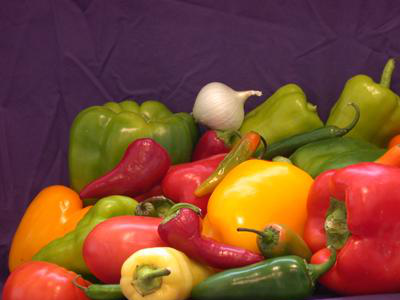

In [48]:
response = requests.get("https://blogs.mathworks.com/images/steve/2008/peppers.jpg")
ig = Image.open(BytesIO(response.content))
img = np.array(ig)
img = pixelate_image(img, int(400 * img.shape[0]/img.shape[1]), 400)
Image.fromarray(np.uint8(img))

In [49]:
df = pd.read_excel (r'data/DMC_Palette.xlsx')
dmc = pd.DataFrame(df, columns = ['R', 'G', 'B'])
dmc_array_rgb = np.array(dmc.values)

(20, 3)
(15504, 15, 3)


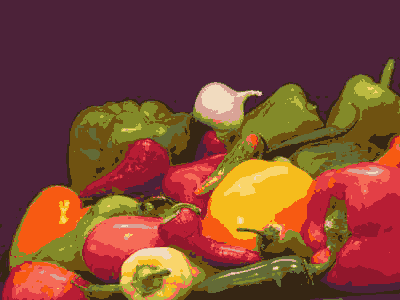

In [56]:
stitch0 = cross_stitch(img, dmc_array_rgb, hueProb, hueJoint, hueAdjacency, 15, 0)
stitch0_image = Image.fromarray(np.uint8(stitch0))
stitch0_image

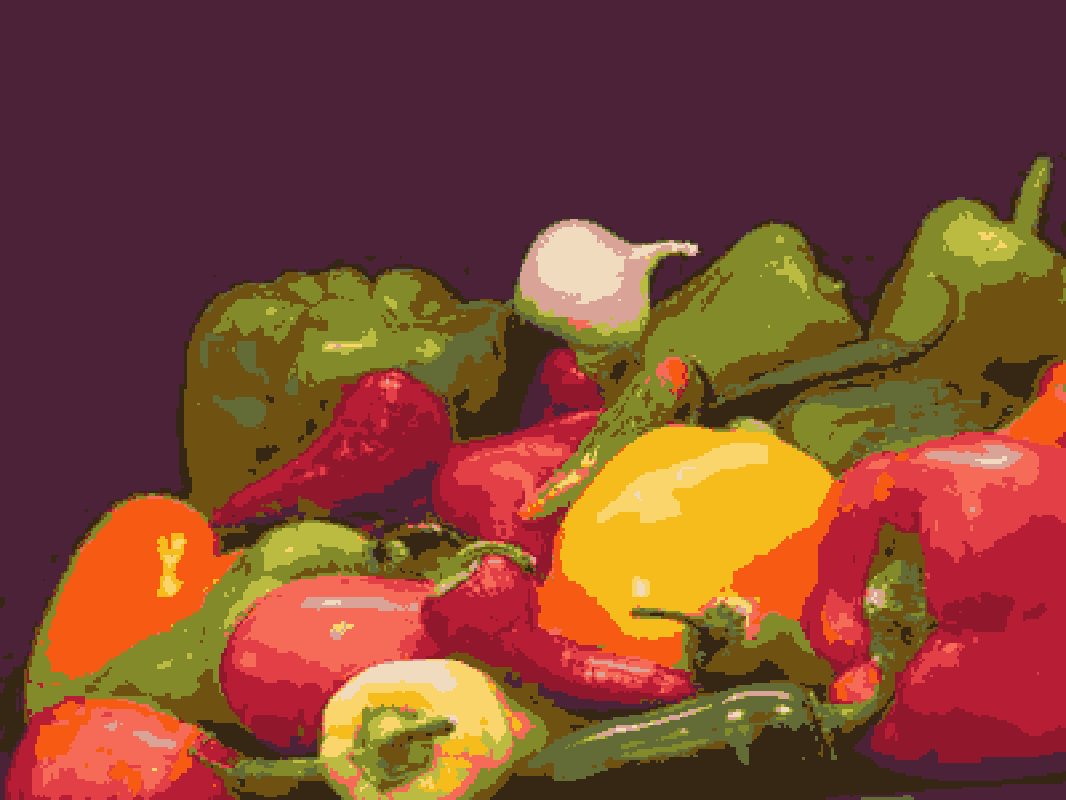

In [57]:
stitch0_image_big = stitch0_image.resize((int(2 * stitch0.shape[1]/stitch0.shape[0] * stitch0.shape[1]), 2 * stitch0.shape[1]), Image.NEAREST)   
stitch0_image_big

(20, 3)
(15504, 15, 3)


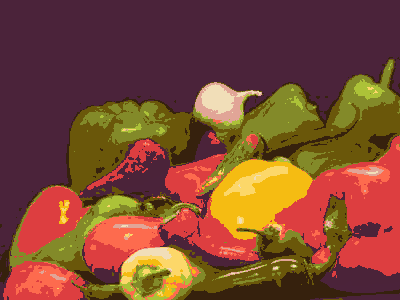

In [61]:
stitch3 = cross_stitch(img, dmc_array_rgb, hueProb, hueJoint, hueAdjacency, 15, 3)
stitch3_image = Image.fromarray(np.uint8(stitch3))
stitch3_image

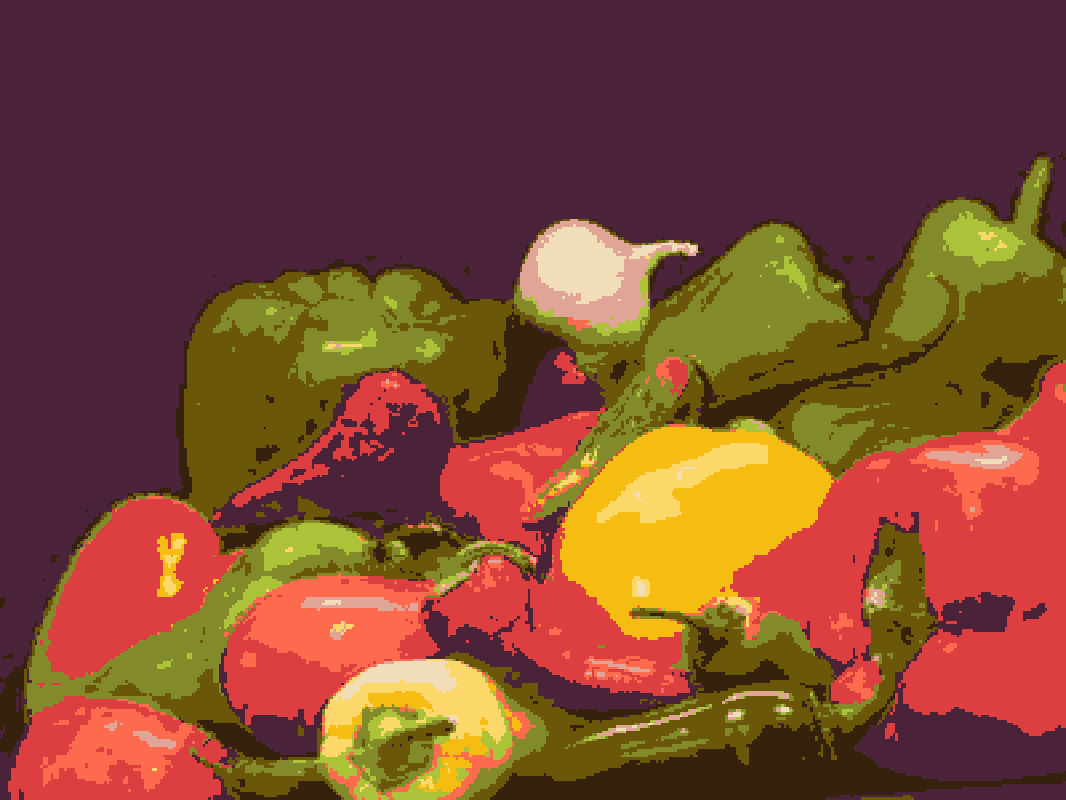

In [62]:
stitch3_image_big = stitch3_image.resize((int(2 * stitch3.shape[1]/stitch3.shape[0] * stitch3.shape[1]), 2 * stitch3.shape[1]), Image.NEAREST)   
stitch3_image_big

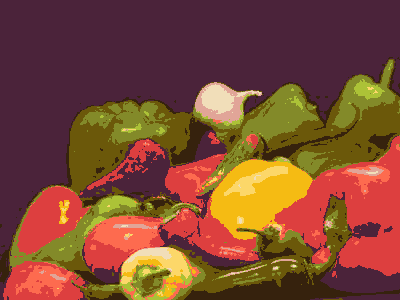

In [63]:
stitch_k_means = cross_stich_k_means(img, dmc_array_rgb, 15)
stitch_k_means_image = Image.fromarray(np.uint8(stitch_k_means))
stitch_k_means_image

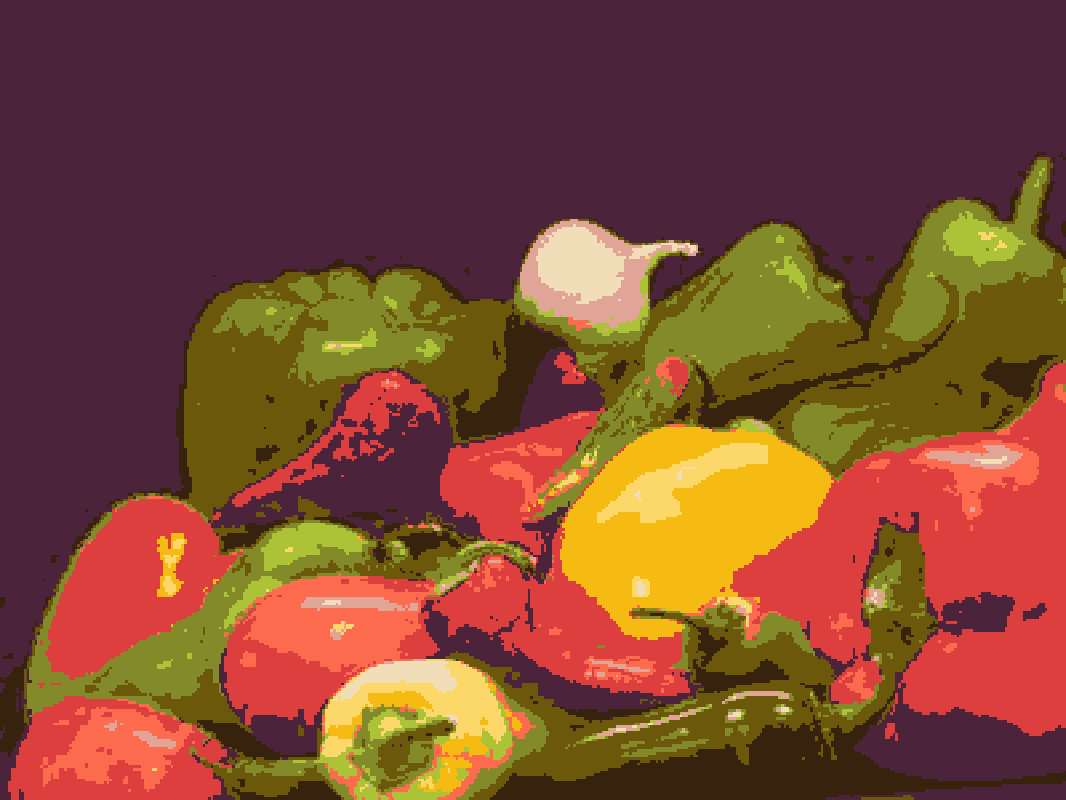

In [64]:
stitch_k_means_big = stitch_k_means_image.resize((int(2 * stitch_k_means.shape[1]/stitch_k_means.shape[0] * stitch_k_means.shape[1]), 2 * stitch_k_means.shape[1]), Image.NEAREST)   
stitch_k_means_big